# Mushroom Stew

## Develop a mushroom stew, that is visually appealing, pleasingly smelling, and preferably non-toxic.

* Explore the fields, which ones could affect the taste or smell, which can be ignored? 
* Which fields may affect if the stew is visually appealing? 
* Use graphics to support your choices

## Import Libraries

In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
from pandas_profiling import ProfileReport
from urllib.request import urlopen
import json
import plotly.graph_objects as go
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics

## Load Dataset, Explore and Display Features

In [2]:
col_names=['class','cap-shape', 'cap-surface', 'cap-color', 'bruises?', 'odor','gill-attachment',\
           'gill-spacing','gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring',\
           'stalk-surface-below-ring','stalk-color-above-ring','stalk-color-below-ring','veil-type',\
           'veil-color','ring-number','ring-type','spore-print-color','population','habitat'] 

mushroom_df = pd.read_csv('expanded.csv', names=col_names, header=None)

In [3]:
pd.set_option("display.max_columns", None)
mushroom_df.head(5)

,class,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
1,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
2,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
3,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
4,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,BROWN,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS


In [4]:
mushroom_df.dtypes

class                       object
cap-shape                   object
cap-surface                 object
cap-color                   object
bruises?                    object
odor                        object
gill-attachment             object
gill-spacing                object
gill-size                   object
gill-color                  object
stalk-shape                 object
stalk-root                  object
stalk-surface-above-ring    object
stalk-surface-below-ring    object
stalk-color-above-ring      object
stalk-color-below-ring      object
veil-type                   object
veil-color                  object
ring-number                 object
ring-type                   object
spore-print-color           object
population                  object
habitat                     object
dtype: object

In [5]:
mushroom_df.describe()

,class,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416,8416
unique,2,6,4,10,2,9,2,2,2,12,2,5,4,4,9,9,1,4,3,5,9,6,7
top,EDIBLE,CONVEX,SCALY,BROWN,NO,NONE,FREE,CLOSE,BROAD,BUFF,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,WHITE,SEVERAL,WOODS
freq,4488,3796,3268,2320,5040,3808,8200,6824,5880,1728,4864,3800,5316,5076,4744,4640,8416,8216,7768,3968,2424,4064,3160


In [6]:
profile = ProfileReport(mushroom_df)
profile

Summarize dataset:   0%|          | 0/36 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Dataframe Expanded into Dummy Variables

In [7]:
df_dummy = pd.get_dummies(mushroom_df, columns=col_names)

df_dummy.head()

,class_EDIBLE,class_POISONOUS,cap-shape_BELL,cap-shape_CONICAL,cap-shape_CONVEX,cap-shape_FLAT,cap-shape_KNOBBED,cap-shape_SUNKEN,cap-surface_FIBROUS,cap-surface_GROOVES,cap-surface_SCALY,cap-surface_SMOOTH,cap-color_BROWN,cap-color_BUFF,cap-color_CINNAMON,cap-color_GRAY,cap-color_GREEN,cap-color_PINK,cap-color_PURPLE,cap-color_RED,cap-color_WHITE,cap-color_YELLOW,bruises?_BRUISES,bruises?_NO,odor_ALMOND,odor_ANISE,odor_CREOSOTE,odor_FISHY,odor_FOUL,odor_MUSTY,odor_NONE,odor_PUNGENT,odor_SPICY,gill-attachment_ATTACHED,gill-attachment_FREE,gill-spacing_CLOSE,gill-spacing_CROWDED,gill-size_BROAD,gill-size_NARROW,gill-color_BLACK,gill-color_BROWN,gill-color_BUFF,gill-color_CHOCOLATE,gill-color_GRAY,gill-color_GREEN,gill-color_ORANGE,gill-color_PINK,gill-color_PURPLE,gill-color_RED,gill-color_WHITE,gill-color_YELLOW,stalk-shape_ENLARGING,stalk-shape_TAPERING,stalk-root_?,stalk-root_BULBOUS,stalk-root_CLUB,stalk-root_EQUAL,stalk-root_ROOTED,stalk-surface-above-ring_FIBROUS,stalk-surface-above-ring_SCALY,stalk-surface-above-ring_SILKY,stalk-surface-above-ring_SMOOTH,stalk-surface-below-ring_FIBROUS,stalk-surface-below-ring_SCALY,stalk-surface-below-ring_SILKY,stalk-surface-below-ring_SMOOTH,stalk-color-above-ring_BROWN,stalk-color-above-ring_BUFF,stalk-color-above-ring_CINNAMON,stalk-color-above-ring_GRAY,stalk-color-above-ring_ORANGE,stalk-color-above-ring_PINK,stalk-color-above-ring_RED,stalk-color-above-ring_WHITE,stalk-color-above-ring_YELLOW,stalk-color-below-ring_BROWN,stalk-color-below-ring_BUFF,stalk-color-below-ring_CINNAMON,stalk-color-below-ring_GRAY,stalk-color-below-ring_ORANGE,stalk-color-below-ring_PINK,stalk-color-below-ring_RED,stalk-color-below-ring_WHITE,stalk-color-below-ring_YELLOW,veil-type_PARTIAL,veil-color_BROWN,veil-color_ORANGE,veil-color_WHITE,veil-color_YELLOW,ring-number_NONE,ring-number_ONE,ring-number_TWO,ring-type_EVANESCENT,ring-type_FLARING,ring-type_LARGE,ring-type_NONE,ring-type_PENDANT,spore-print-color_BLACK,spore-print-color_BROWN,spore-print-color_BUFF,spore-print-color_CHOCOLATE,spore-print-color_GREEN,spore-print-color_ORANGE,spore-print-color_PURPLE,spore-print-color_WHITE,spore-print-color_YELLOW,population_ABUNDANT,population_CLUSTERED,population_NUMEROUS,population_SCATTERED,population_SEVERAL,population_SOLITARY,habitat_GRASSES,habitat_LEAVES,habitat_MEADOWS,habitat_PATHS,habitat_URBAN,habitat_WASTE,habitat_WOODS
0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


## Correlation Heatmaps

In [8]:
cap_xtab = pd.crosstab(mushroom_df['class'],\
                   columns=[mushroom_df['cap-shape'], mushroom_df['cap-surface'], \
                            mushroom_df['cap-color'], mushroom_df['bruises?']]) 

gill_xtab = pd.crosstab(mushroom_df['class'],\
                    columns=[mushroom_df['odor'],mushroom_df['gill-attachment'],\
                            mushroom_df['gill-spacing'], mushroom_df['gill-size'], \
                            mushroom_df['gill-color']])

stalk_xtab = pd.crosstab(mushroom_df['class'],\
                     columns=[mushroom_df['stalk-shape'],mushroom_df['stalk-root'],\
                            mushroom_df['stalk-surface-above-ring'],\
                            mushroom_df['stalk-surface-below-ring'],\
                            mushroom_df['stalk-color-above-ring'],\
                            mushroom_df['stalk-color-below-ring']])

other_xtab = pd.crosstab(mushroom_df['class'],\
                    columns=[mushroom_df['veil-type'],mushroom_df['veil-color'],\
                            mushroom_df['ring-number'],mushroom_df['spore-print-color'],
                            mushroom_df['population'], mushroom_df['habitat']])


In [9]:
gill_xtab

odor            ALMOND                                          ANISE        \
gill-attachment   FREE                                           FREE         
gill-spacing     CLOSE                       CROWDED            CLOSE         
gill-size        BROAD                        NARROW            BROAD         
gill-color       BLACK BROWN GRAY PINK WHITE   BROWN PINK WHITE BLACK BROWN   
class                                                                         
EDIBLE              64    96   64   32    96      16   16    16    64    96   
POISONOUS            0     0    0    0     0       0    0     0     0     0   

odor                                               CREOSOTE                   \
gill-attachment                                        FREE                    
gill-spacing                    CROWDED               CLOSE                    
gill-size                        NARROW              NARROW                    
gill-color      GRAY PINK WHITE   BROWN PINK WHITE    BROWN GRAY PINK PURPLE   
class                                                                          
EDIBLE            64   32    96      16   16    16        0    0    0      0   
POISONOUS          0    0     0       0    0     0       24   24   24     24   

odor                                      FISHY      FOUL                  \
gill-attachment                            FREE      FREE                   
gill-spacing    CROWDED                   CLOSE     CLOSE                   
gill-size        NARROW                  NARROW     BROAD                   
gill-color        BROWN GRAY PINK PURPLE   BUFF CHOCOLATE GRAY PINK WHITE   
class                                                                       
EDIBLE                0    0    0      0      0         0    0    0     0   
POISONOUS            24   24   24     24    576       528  432  528    96   

odor                      MUSTY                         NONE                \
gill-attachment        ATTACHED         FREE        ATTACHED                 
gill-spacing              CLOSE        CLOSE           CLOSE                 
gill-size       NARROW    BROAD        BROAD           BROAD                 
gill-color        BUFF    WHITE YELLOW WHITE YELLOW    BROWN ORANGE YELLOW   
class                                                                        
EDIBLE               0        0      0     0      0       64     64     64   
POISONOUS          576       12     12    12     12        0      0      0   

odor                                                                           \
gill-attachment  FREE                                                           
gill-spacing    CLOSE                                                           
gill-size       BROAD                                  NARROW                   
gill-color      BROWN GRAY GREEN PINK PURPLE RED WHITE  BLACK BROWN CHOCOLATE   
class                                                                           
EDIBLE            432    0     0  432    432  96   576     24    24        12   
POISONOUS           0   24    24    0      0   0    24      0     0         0   

odor                                                                      \
gill-attachment                                                            
gill-spacing                           CROWDED                             
gill-size                                BROAD                             
gill-color      GRAY PINK PURPLE WHITE   BLACK BROWN CHOCOLATE GRAY PINK   
class                                                                      
EDIBLE            24   36     12    12     256   256       256   96  352   
POISONOUS          0    0      0    32       0     0         0    0    0   

odor                                PUNGENT                   SPICY  
gill-attachment                        FREE                    FREE  
gill-spacing                          CLOSE                   CLOSE  
gill-size       

<AxesSubplot:xlabel='cap-shape-cap-surface-cap-color-bruises?', ylabel='class'>

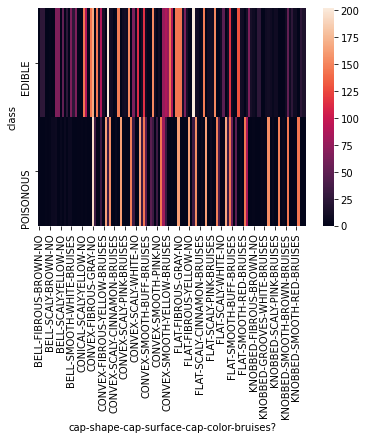

In [10]:
sns.heatmap(cap_xtab)

<AxesSubplot:xlabel='odor-gill-attachment-gill-spacing-gill-size-gill-color', ylabel='class'>

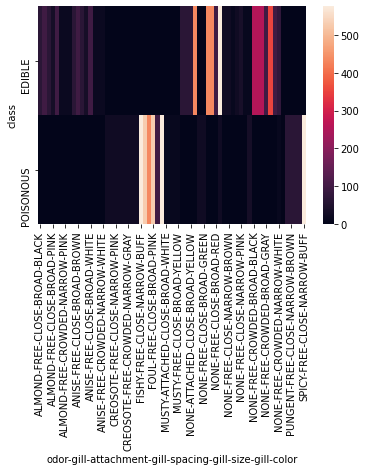

In [11]:
sns.heatmap(gill_xtab)

<AxesSubplot:xlabel='stalk-shape-stalk-root-stalk-surface-above-ring-stalk-surface-below-ring-stalk-color-above-ring-stalk-color-below-ring', ylabel='class'>

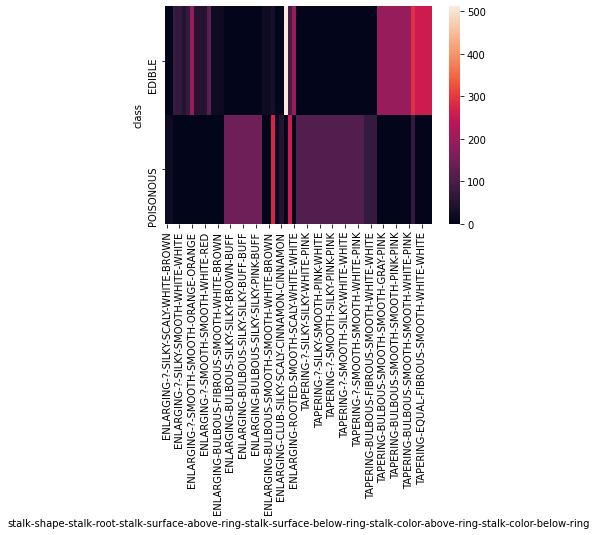

In [12]:
sns.heatmap(stalk_xtab)

<AxesSubplot:xlabel='veil-type-veil-color-ring-number-spore-print-color-population-habitat', ylabel='class'>

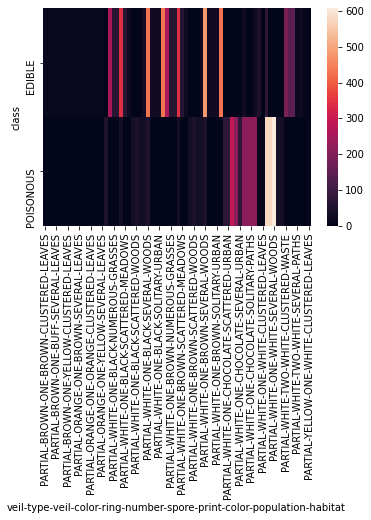

In [13]:
sns.heatmap(other_xtab)

## Feature Engineering

### The field, veil-type, doesn't contribute any information (all are the same value) and can be dropped from the dataset

In [14]:
mushroom_df_adj = mushroom_df.drop('veil-type', axis=1)
mushroom_df_adj.shape

(8416, 22)

### Label encode the "class" column and encode the input columns using get_dummies

In [15]:
# Don't convert "class" column to dummies, convert to Binary instead using LabelEncoder

# label_encoder object
label_encoder =LabelEncoder()
# Encode labels in column. 
mushroom_df_adj['class']= label_encoder.fit_transform(mushroom_df_adj['class']) # 0 is Edible, 1 is Poisonous

col_names_dummies=['cap-shape', 'cap-surface', 'cap-color', 'bruises?', 'odor','gill-attachment',\
           'gill-spacing','gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring',\
           'stalk-surface-below-ring','stalk-color-above-ring','stalk-color-below-ring',\
           'veil-color','ring-number','ring-type','spore-print-color','population','habitat'] 

In [16]:
# drop_first = True helps avoid multicollinearity
df_dummy2 = pd.get_dummies(mushroom_df_adj, columns=col_names_dummies, drop_first=True)
df_dummy2.head()

,class,cap-shape_CONICAL,cap-shape_CONVEX,cap-shape_FLAT,cap-shape_KNOBBED,cap-shape_SUNKEN,cap-surface_GROOVES,cap-surface_SCALY,cap-surface_SMOOTH,cap-color_BUFF,cap-color_CINNAMON,cap-color_GRAY,cap-color_GREEN,cap-color_PINK,cap-color_PURPLE,cap-color_RED,cap-color_WHITE,cap-color_YELLOW,bruises?_NO,odor_ANISE,odor_CREOSOTE,odor_FISHY,odor_FOUL,odor_MUSTY,odor_NONE,odor_PUNGENT,odor_SPICY,gill-attachment_FREE,gill-spacing_CROWDED,gill-size_NARROW,gill-color_BROWN,gill-color_BUFF,gill-color_CHOCOLATE,gill-color_GRAY,gill-color_GREEN,gill-color_ORANGE,gill-color_PINK,gill-color_PURPLE,gill-color_RED,gill-color_WHITE,gill-color_YELLOW,stalk-shape_TAPERING,stalk-root_BULBOUS,stalk-root_CLUB,stalk-root_EQUAL,stalk-root_ROOTED,stalk-surface-above-ring_SCALY,stalk-surface-above-ring_SILKY,stalk-surface-above-ring_SMOOTH,stalk-surface-below-ring_SCALY,stalk-surface-below-ring_SILKY,stalk-surface-below-ring_SMOOTH,stalk-color-above-ring_BUFF,stalk-color-above-ring_CINNAMON,stalk-color-above-ring_GRAY,stalk-color-above-ring_ORANGE,stalk-color-above-ring_PINK,stalk-color-above-ring_RED,stalk-color-above-ring_WHITE,stalk-color-above-ring_YELLOW,stalk-color-below-ring_BUFF,stalk-color-below-ring_CINNAMON,stalk-color-below-ring_GRAY,stalk-color-below-ring_ORANGE,stalk-color-below-ring_PINK,stalk-color-below-ring_RED,stalk-color-below-ring_WHITE,stalk-color-below-ring_YELLOW,veil-color_ORANGE,veil-color_WHITE,veil-color_YELLOW,ring-number_ONE,ring-number_TWO,ring-type_FLARING,ring-type_LARGE,ring-type_NONE,ring-type_PENDANT,spore-print-color_BROWN,spore-print-color_BUFF,spore-print-color_CHOCOLATE,spore-print-color_GREEN,spore-print-color_ORANGE,spore-print-color_PURPLE,spore-print-color_WHITE,spore-print-color_YELLOW,population_CLUSTERED,population_NUMEROUS,population_SCATTERED,population_SEVERAL,population_SOLITARY,habitat_LEAVES,habitat_MEADOWS,habitat_PATHS,habitat_URBAN,habitat_WASTE,habitat_WOODS
0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1


## Run 6 Classifier Models

In [17]:
y = df_dummy2["class"].values
X = df_dummy2.drop(["class"], axis=1).values
# Split data for train and test.
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.2)

In [42]:
matplotlib.rcParams['figure.figsize'] = [12, 8]
sns.set_style('darkgrid')
sns.set(font_scale=1.2)
%matplotlib inline

In [39]:
def classification(method, x_dat, y_dat, **params): # I took classification type out but we might want it)
    
    # Split data for train and test
    X_train, X_test, y_train, y_test = train_test_split(x_dat,y_dat,random_state=42,test_size=0.2)
    
    #fit model
    mod = method(**params)
    mod.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
    
    #print results
    print("Results for {}:".format(str(method)))
    print(classification_report(y_pred, y_test))
    print("Test Accuracy: {}%".format(round(mod.score(X_test,y_test)*100,2)))
    
    #print confusion matrix
    y_pred_rf = y_pred
    y_true_rf = y_test
    cm = confusion_matrix(y_true_rf, y_pred_rf)
    f, ax = plt.subplots(figsize =(5,5))
    sns.heatmap(cm,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
    plt.xlabel("y_pred_rf")
    plt.ylabel("y_true_rf")
    plt.title('Confusion Matrix')
    plt.show()
    
    if method == DecisionTreeClassifier:
        print('Feature Importance Plot')
        sns.barplot(y=x_dat.columns, x=mod.feature_importances_)
        plt.xlabel('Mean Decrease Gini')
        plt.show()
        
    if method == DecisionTreeClassifier:
        plot_tree(mod.fit(X_train, y_train))

In [36]:
x_mushroom = df_dummy2.drop(["class"], axis=1)
y_mushroom = df_dummy2["class"]

In [45]:
# Split data for train and test
X_train_DT, X_test_DT, y_train_DT, y_test_DT = train_test_split(x_mushroom,y_mushroom,random_state=42,test_size=0.2)

#fit model
DT_mod = DecisionTreeClassifier()
DT_mod.fit(X_train_DT, y_train_DT)
y_pred = DT_mod.predict(X_test_DT)        

Feature Importance Plot


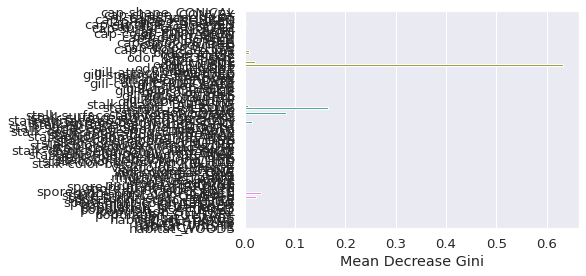

In [46]:
print('Feature Importance Plot')
sns.barplot(y=x_mushroom.columns, x=DT_mod.feature_importances_)
plt.xlabel('Mean Decrease Gini')
plt.show()

In [51]:
text_representation = tree.export_text(DT_mod)
print(text_representation)

|--- feature_23 <= 0.50
|   |--- feature_42 <= 0.50
|   |   |--- feature_48 <= 0.50
|   |   |   |--- feature_81 <= 0.50
|   |   |   |   |--- feature_18 <= 0.50
|   |   |   |   |   |--- feature_27 <= 0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_27 >  0.50
|   |   |   |   |   |   |--- feature_40 <= 0.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- feature_40 >  0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_18 >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- feature_81 >  0.50
|   |   |   |   |--- class: 0
|   |   |--- feature_48 >  0.50
|   |   |   |--- class: 0
|   |--- feature_42 >  0.50
|   |   |--- feature_46 <= 0.50
|   |   |   |--- class: 0
|   |   |--- feature_46 >  0.50
|   |   |   |--- class: 1
|--- feature_23 >  0.50
|   |--- feature_79 <= 0.50
|   |   |--- feature_48 <= 0.50
|   |   |   |--- feature_5 <= 0.50
|   |   |   |   |--- feature_28 <= 0.50
|   |   |   |   |   |--- class: 0

In [54]:
feature_names = df_dummy2.drop(["class"], axis=1).columns
feature_names

Index(['cap-shape_CONICAL', 'cap-shape_CONVEX', 'cap-shape_FLAT',
       'cap-shape_KNOBBED', 'cap-shape_SUNKEN', 'cap-surface_GROOVES',
       'cap-surface_SCALY', 'cap-surface_SMOOTH', 'cap-color_BUFF',
       'cap-color_CINNAMON', 'cap-color_GRAY', 'cap-color_GREEN',
       'cap-color_PINK', 'cap-color_PURPLE', 'cap-color_RED',
       'cap-color_WHITE', 'cap-color_YELLOW', 'bruises?_NO', 'odor_ANISE',
       'odor_CREOSOTE', 'odor_FISHY', 'odor_FOUL', 'odor_MUSTY', 'odor_NONE',
       'odor_PUNGENT', 'odor_SPICY', 'gill-attachment_FREE',
       'gill-spacing_CROWDED', 'gill-size_NARROW', 'gill-color_BROWN',
       'gill-color_BUFF', 'gill-color_CHOCOLATE', 'gill-color_GRAY',
       'gill-color_GREEN', 'gill-color_ORANGE', 'gill-color_PINK',
       'gill-color_PURPLE', 'gill-color_RED', 'gill-color_WHITE',
       'gill-color_YELLOW', 'stalk-shape_TAPERING', 'stalk-root_BULBOUS',
       'stalk-root_CLUB', 'stalk-root_EQUAL', 'stalk-root_ROOTED',
       'stalk-surface-above-ring_SCALY'

In [63]:
class_names = df_dummy2["class"]
class_names

0       0
1       0
2       0
3       0
4       0
       ..
8411    0
8412    0
8413    0
8414    0
8415    0
Name: class, Length: 8416, dtype: int64

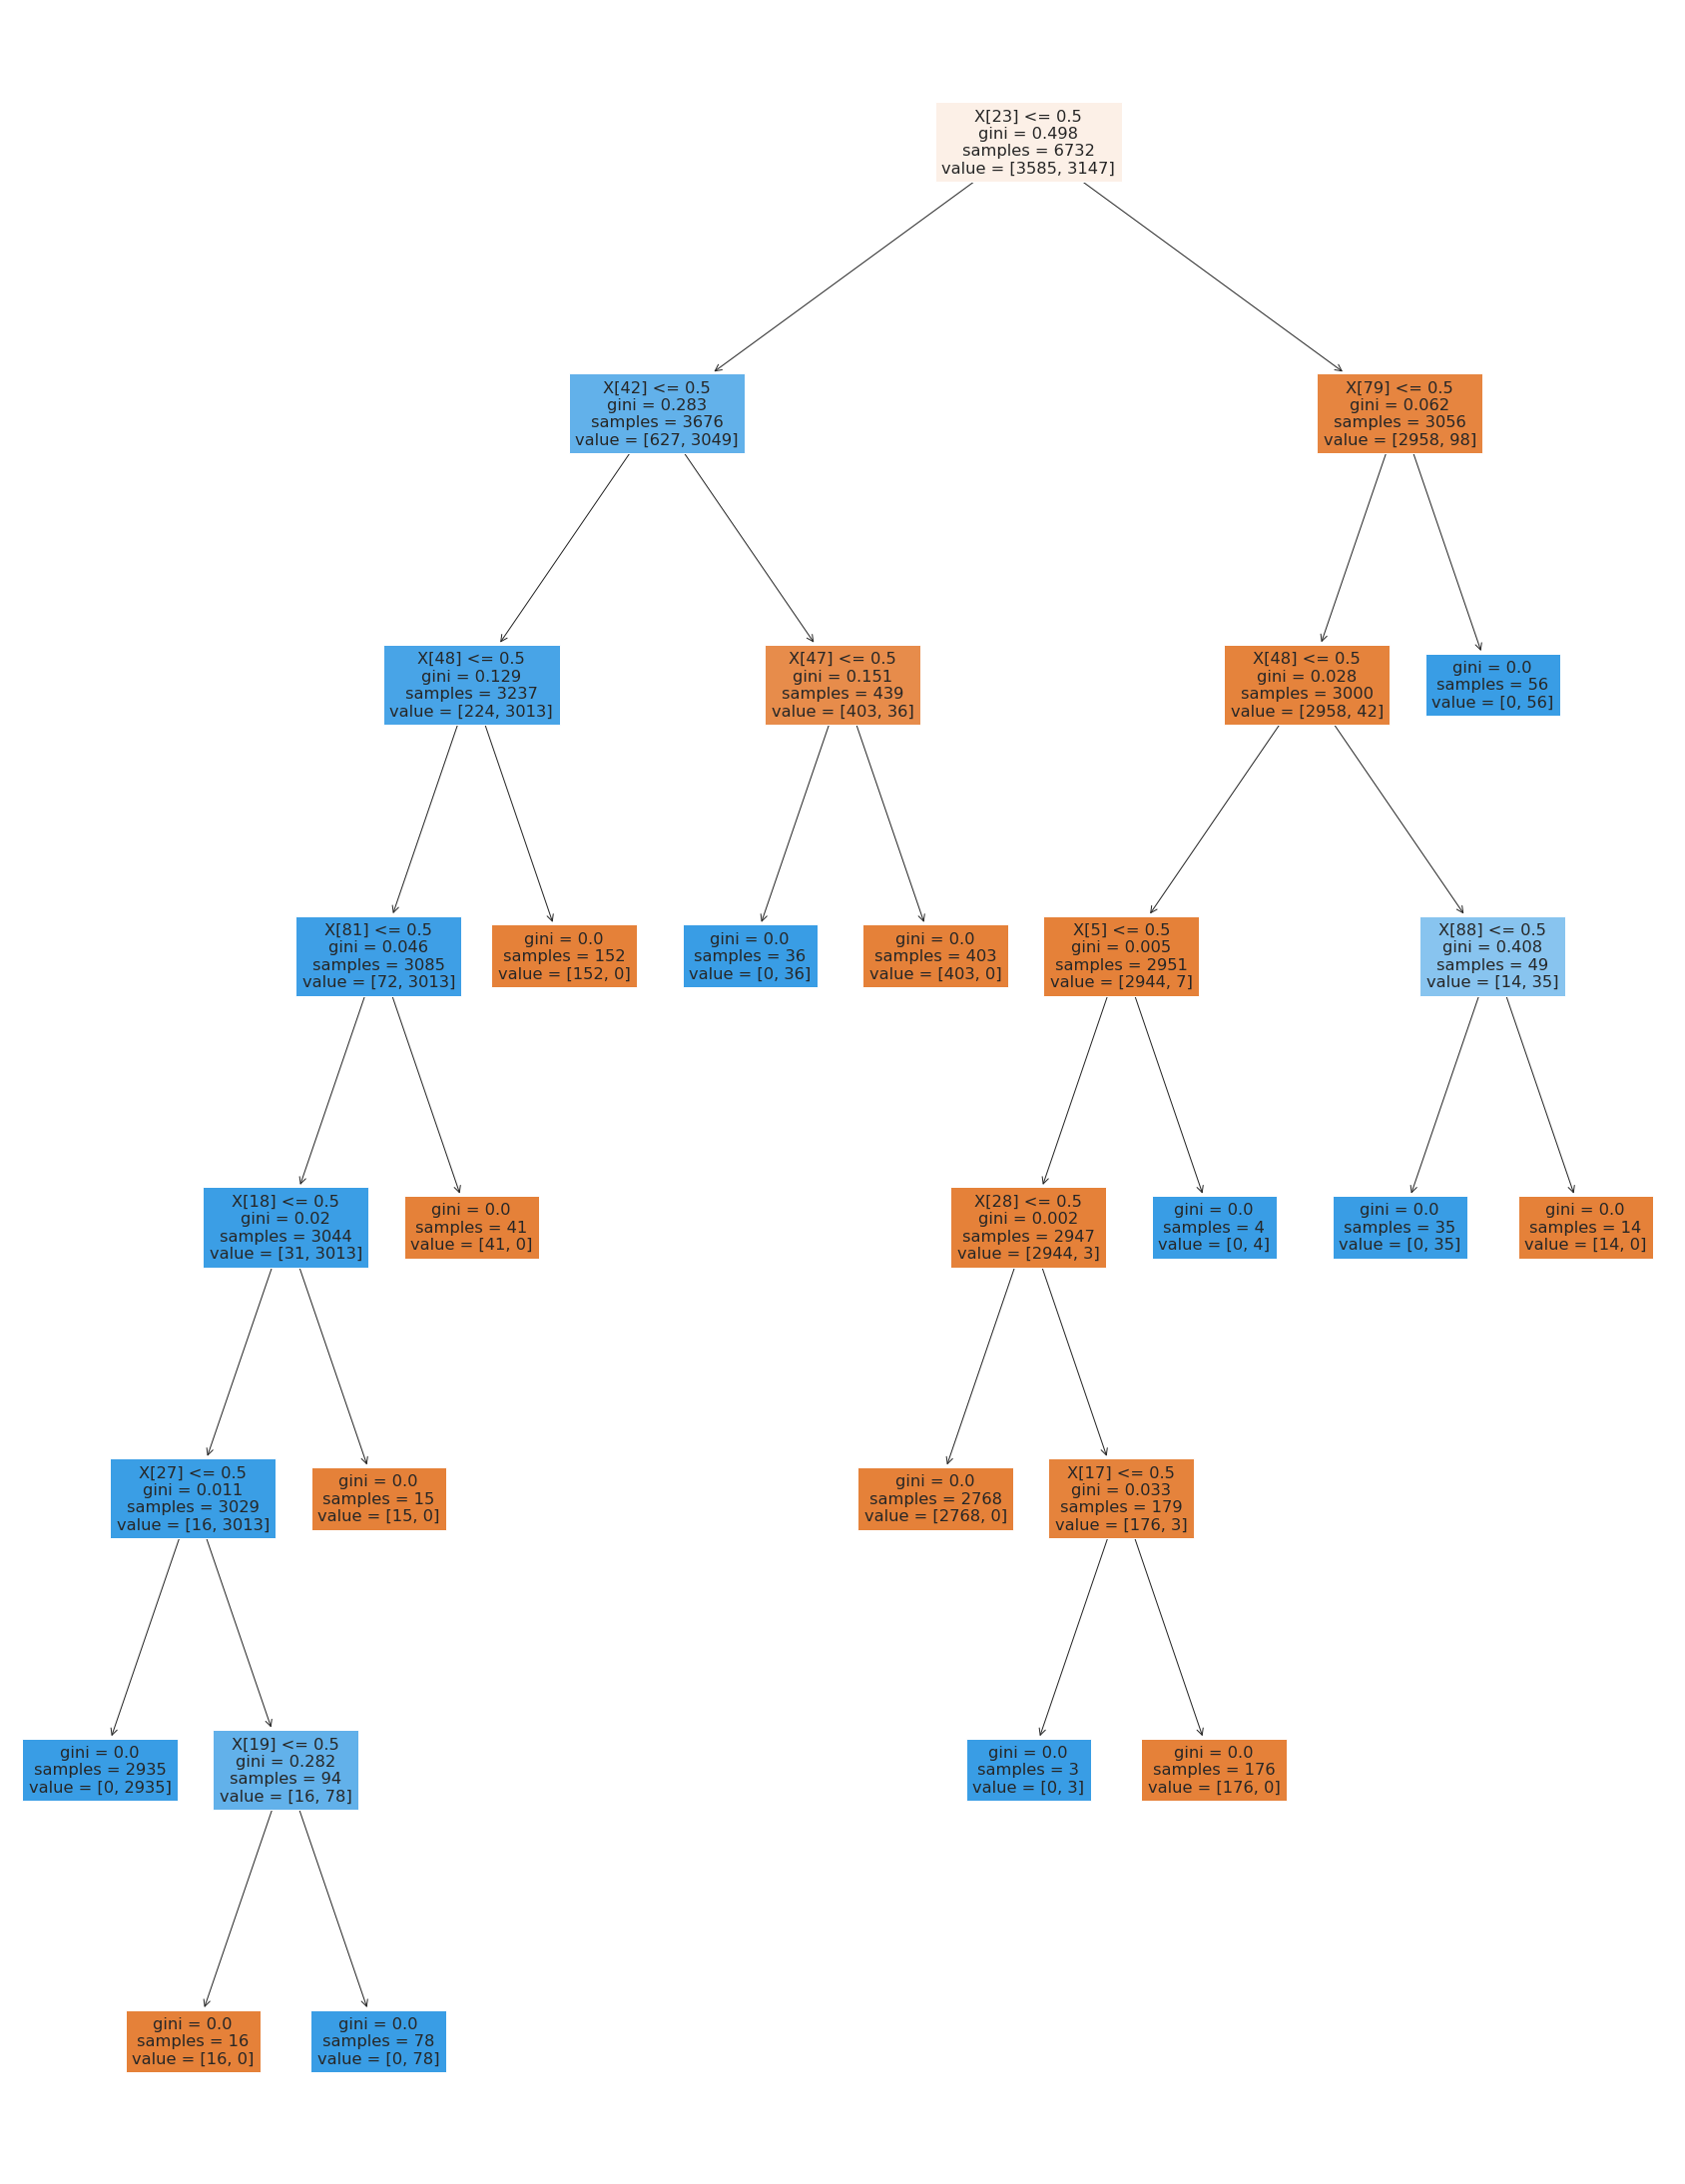

In [62]:
fig = plt.figure(figsize=(30,40))
plot_tree(DT_mod,filled=True);  

#feature_names = df_dummy2.drop(["class"], axis=1).columns
#feature_names=iris.feature_names, class_names=iris.target_names

Results for <class 'sklearn.tree._classes.DecisionTreeClassifier'>:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       903
           1       1.00      1.00      1.00       781

    accuracy                           1.00      1684
   macro avg       1.00      1.00      1.00      1684
weighted avg       1.00      1.00      1.00      1684

Test Accuracy: 100.0%


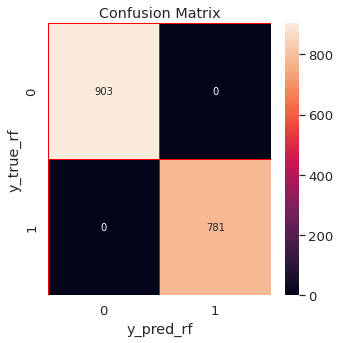

Feature Importance Plot


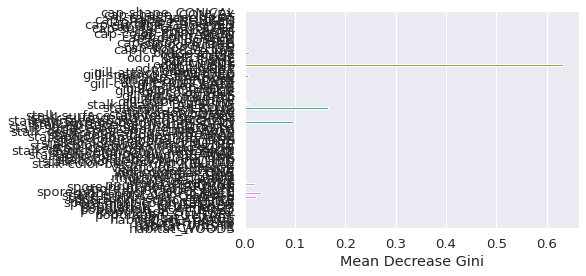

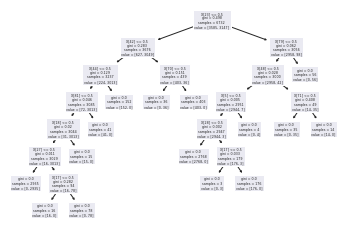

In [40]:
classification(DecisionTreeClassifier, x_mushroom, y_mushroom)

Results for <class 'sklearn.svm._classes.SVC'>:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       904
           1       1.00      1.00      1.00       780

    accuracy                           1.00      1684
   macro avg       1.00      1.00      1.00      1684
weighted avg       1.00      1.00      1.00      1684

Test Accuracy: 99.94%


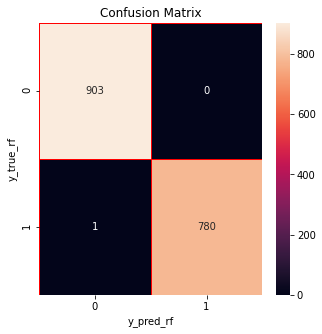

In [21]:
classification(SVC, x_mushroom, y_mushroom, random_state=42, gamma="auto") # check on parameters, did better with default

Results for <class 'sklearn.neighbors._classification.KNeighborsClassifier'>:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       903
           1       1.00      1.00      1.00       781

    accuracy                           1.00      1684
   macro avg       1.00      1.00      1.00      1684
weighted avg       1.00      1.00      1.00      1684

Test Accuracy: 100.0%


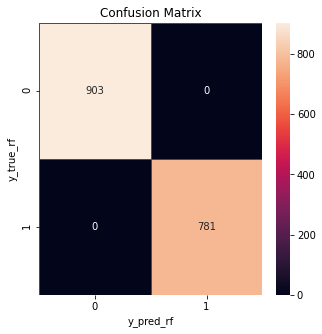

In [22]:

classification(KNeighborsClassifier, x_mushroom, y_mushroom, n_neighbors=5)

Results for <class 'sklearn.linear_model._logistic.LogisticRegression'>:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       903
           1       1.00      1.00      1.00       781

    accuracy                           1.00      1684
   macro avg       1.00      1.00      1.00      1684
weighted avg       1.00      1.00      1.00      1684

Test Accuracy: 100.0%


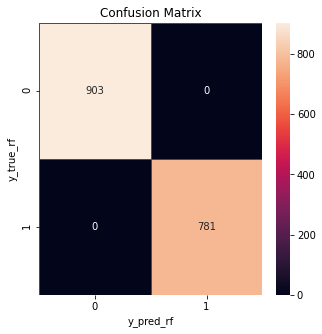

In [23]:
classification(LogisticRegression, x_mushroom, y_mushroom) # on parameters

Results for <class 'sklearn.naive_bayes.GaussianNB'>:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       895
           1       1.00      0.99      0.99       789

    accuracy                           1.00      1684
   macro avg       1.00      0.99      1.00      1684
weighted avg       1.00      1.00      1.00      1684

Test Accuracy: 99.52%


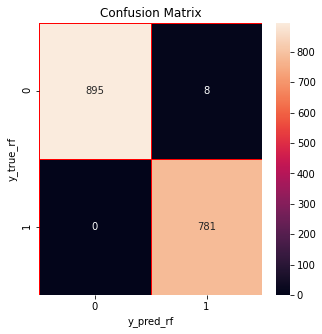

In [24]:
classification(GaussianNB, x_mushroom, y_mushroom)

Results for <class 'sklearn.ensemble._forest.RandomForestClassifier'>:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       903
           1       1.00      1.00      1.00       781

    accuracy                           1.00      1684
   macro avg       1.00      1.00      1.00      1684
weighted avg       1.00      1.00      1.00      1684

Test Accuracy: 100.0%


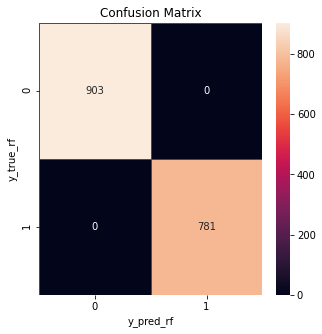

In [25]:
classification(RandomForestClassifier, x_mushroom, y_mushroom, n_estimators=100, random_state=42) #check on parameters

Results for <class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       904
           1       1.00      1.00      1.00       780

    accuracy                           1.00      1684
   macro avg       1.00      1.00      1.00      1684
weighted avg       1.00      1.00      1.00      1684

Test Accuracy: 99.94%


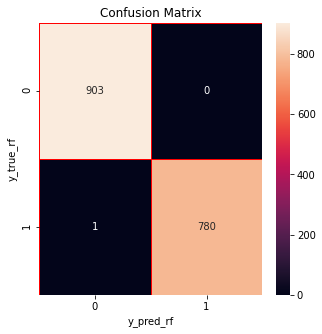

In [26]:
classification(LinearDiscriminantAnalysis, x_mushroom, y_mushroom) #check parameters

Results for <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       903
           1       1.00      1.00      1.00       781

    accuracy                           1.00      1684
   macro avg       1.00      1.00      1.00      1684
weighted avg       1.00      1.00      1.00      1684

Test Accuracy: 100.0%


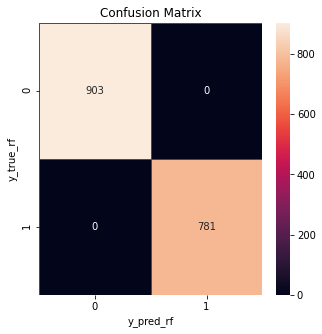

In [27]:
# Neural Network Multi-layer Perceptron Classifier

classification(MLPClassifier, x_mushroom, y_mushroom)

In [28]:
set(mushroom_df['odor'])

{'ALMOND',
 'ANISE',
 'CREOSOTE',
 'FISHY',
 'FOUL',
 'MUSTY',
 'NONE',
 'PUNGENT',
 'SPICY'}

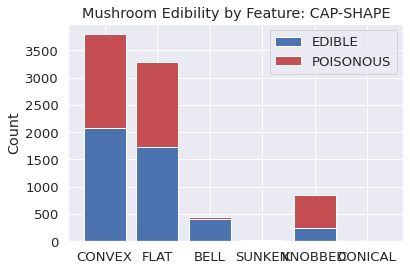

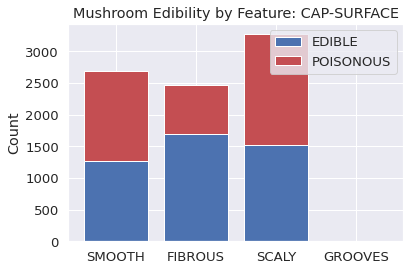

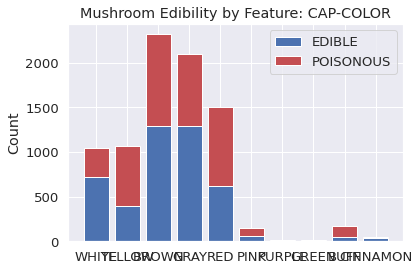

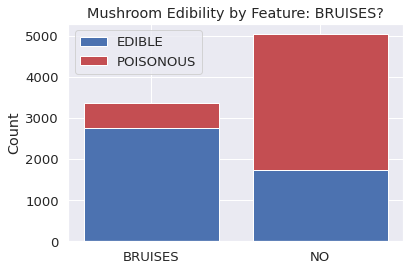

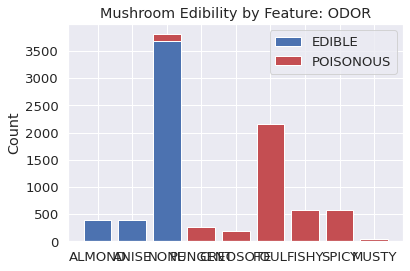

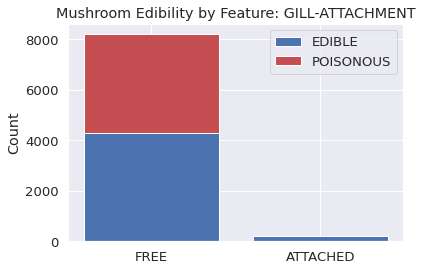

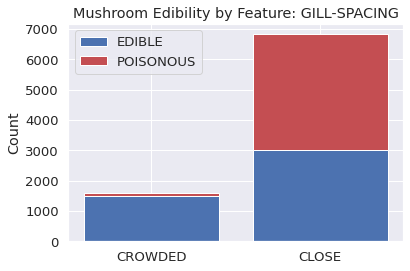

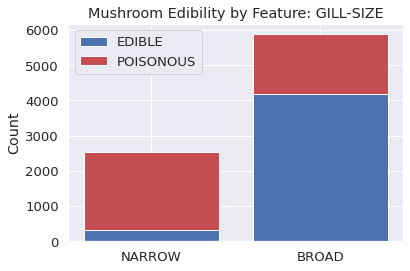

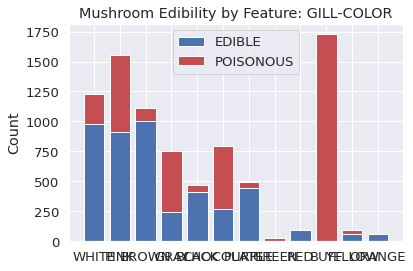

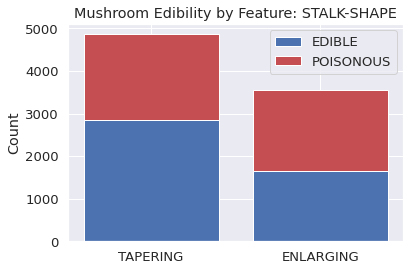

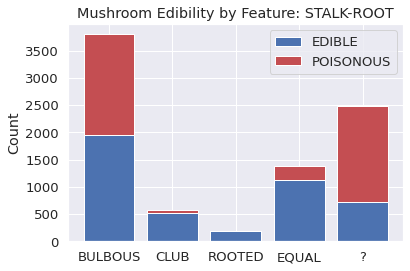

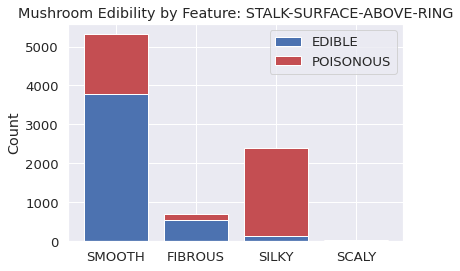

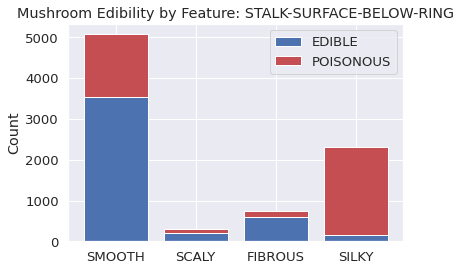

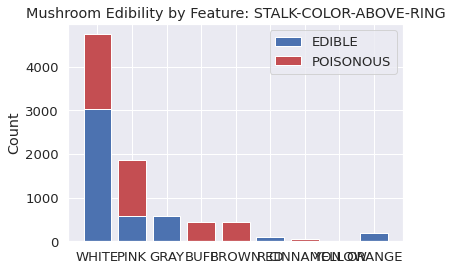

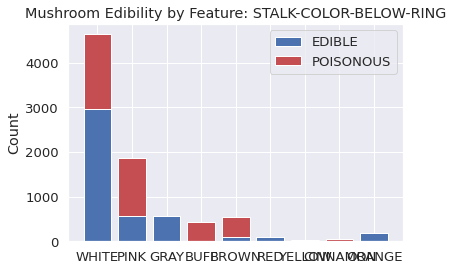

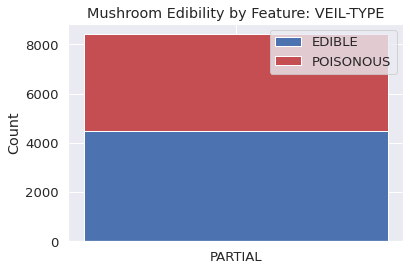

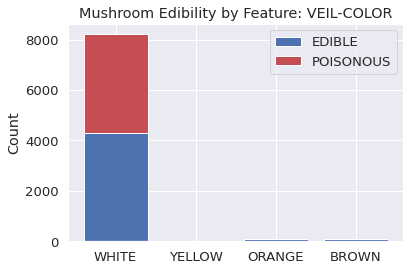

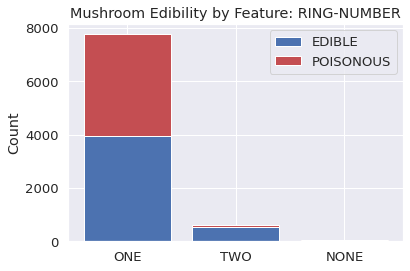

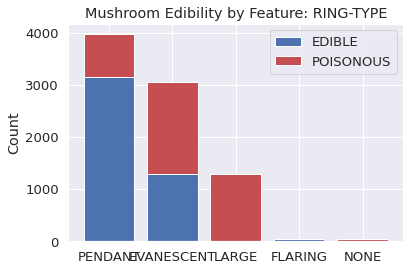

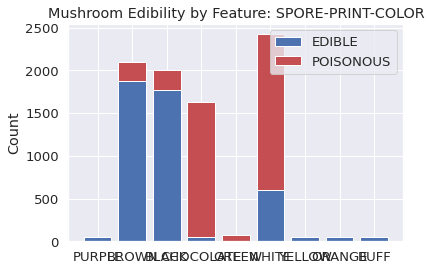

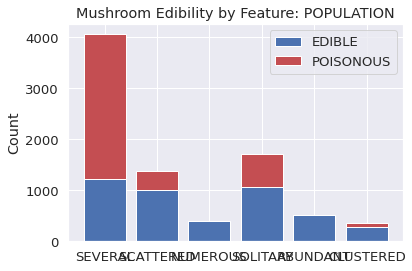

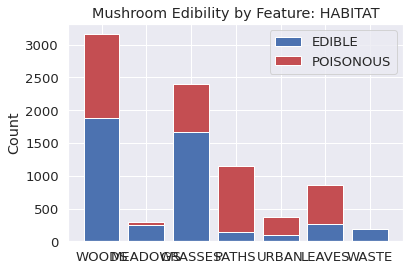

In [43]:
for column in mushroom_df.drop(["class"], axis=1).columns:
    uniq_vals = mushroom_df[column].unique()
    count_edible=[]
    count_poison=[]
    for j in uniq_vals:
        count_edible.append(len(mushroom_df[(mushroom_df[column]==j)
                                            & (mushroom_df['class']=='EDIBLE')]))
        count_poison.append(len(mushroom_df[(mushroom_df[column]==j)
                                            & (mushroom_df['class']=='POISONOUS')]))
    fig, ax = plt.subplots()
    
    ax.bar(uniq_vals, count_edible, label='EDIBLE',color='b')
    ax.bar(uniq_vals, count_poison, label='POISONOUS', bottom=count_edible,color='r')

    ax.set_ylabel('Count')
    ax.set_title('Mushroom Edibility by Feature: '+column.upper())
    ax.legend()

    plt.show()

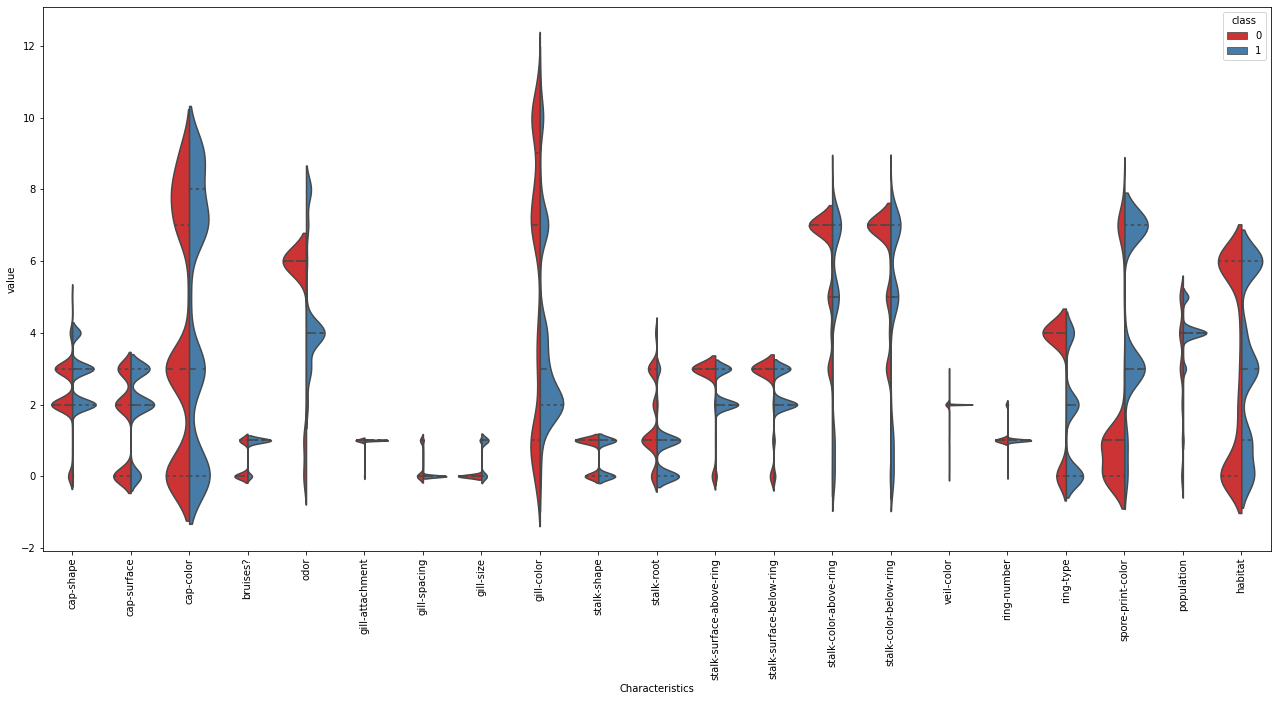

In [30]:
labelencoder=LabelEncoder()
mushroom_df_encoded = mushroom_df.copy()
for column in mushroom_df_encoded.columns:
    mushroom_df_encoded[column] = labelencoder.fit_transform(mushroom_df_encoded[column])

df_div = pd.melt(mushroom_df_encoded.drop("veil-type",axis=1),
                 'class', var_name='Characteristics')
fig, ax = plt.subplots(figsize=(22,10))

p = sns.violinplot(ax = ax, x='Characteristics', y='value',
                   hue='class', split = True, data=df_div,
                   inner = 'quartile', palette = 'Set1')

df_no_class = mushroom_df_encoded.drop(['class','veil-type'],axis = 1)
p.set_xticklabels(rotation = 90, labels = list(df_no_class.columns))

plt.show()

### Pleasantly Smelling

In [31]:
good_odor = ['ALMOND','ANISE','SPICY'] # Up to interpretation I suppose

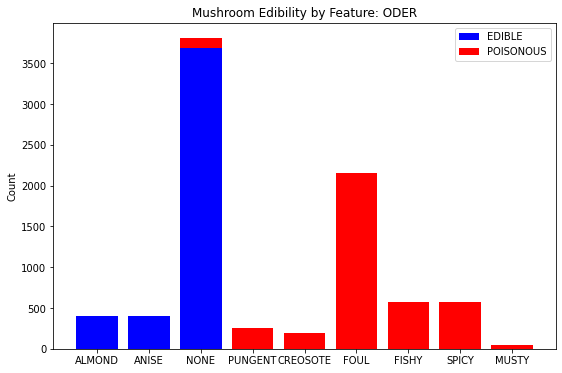

In [32]:
uniq_vals = mushroom_df['odor'].unique()
count_edible=[]
count_poison=[]
for j in uniq_vals:
    count_edible.append(len(mushroom_df[(mushroom_df['odor']==j)
                                            & (mushroom_df['class']=='EDIBLE')]))
    count_poison.append(len(mushroom_df[(mushroom_df['odor']==j)
                                            & (mushroom_df['class']=='POISONOUS')]))
fig, ax = plt.subplots(figsize=(9,6))

ax.bar(uniq_vals, count_edible, label='EDIBLE',color='b')
ax.bar(uniq_vals, count_poison, label='POISONOUS', bottom=count_edible,color='r')

ax.set_ylabel('Count')
ax.set_title('Mushroom Edibility by Feature: ODER')
ax.legend()

plt.show()

We can see from the above plot that nearly all mushrooms with a smell that is not Almond, Anise, or None are Poisonous.